#1. Imports


In [50]:
import tensorflow as tf
import os
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from math import ceil
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2
import pickle

In [51]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. load the dir

In [53]:
data_dir = '/content/drive/My Drive/happy_sad_mod_c/data'
happy_dir = '/content/drive/My Drive/happy_sad_mod_c/data/happy'
sad_dir = '/content/drive/My Drive/happy_sad_mod_c/data/sad'

# 3. Load Data

In [54]:
def load_images_from_dir(directory):
    X = []
    y = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = load_img(os.path.join(directory, filename), target_size=(150, 150))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            X.append(img_array)
            if directory == happy_dir:
                y.append(0)  # Label 0 for happy
            elif directory == sad_dir:
                y.append(1)  # Label 1 for sad
    return X, y

###3.1Load and preprocess images from directories

In [55]:
happy_X, happy_y = load_images_from_dir(happy_dir)
sad_X, sad_y = load_images_from_dir(sad_dir)

###3.2 Combine happy and sad data

In [56]:
X = np.array(happy_X + sad_X)
y = np.array(happy_y + sad_y)

###3.3.Split data into train and test sets

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###3.4 Data augmentation

In [58]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

###3.5  Load pre-trained VGG16 model

In [59]:
vgg16_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

###3.6 Freeze convolutional base

In [60]:
vgg16_base.trainable = False

###3.7 Create new model on top of VGG16

In [61]:
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


###3.8 Compile the model

In [63]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#4. Training

In [64]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=ceil(len(X_train) / 32),
    epochs=30,
    validation_data=(X_test, y_test)
)

Epoch 1/30
76/76 [==============================] - 18s 208ms/step - loss: 0.6453 - accuracy: 0.6407 - val_loss: 0.5318 - val_accuracy: 0.7653
Epoch 2/30
76/76 [==============================] - 16s 204ms/step - loss: 0.5409 - accuracy: 0.7144 - val_loss: 0.5003 - val_accuracy: 0.7504
Epoch 3/30
76/76 [==============================] - 16s 204ms/step - loss: 0.5213 - accuracy: 0.7459 - val_loss: 0.4632 - val_accuracy: 0.7884
Epoch 4/30
76/76 [==============================] - 15s 204ms/step - loss: 0.4853 - accuracy: 0.7682 - val_loss: 0.4586 - val_accuracy: 0.8099
Epoch 5/30
76/76 [==============================] - 15s 202ms/step - loss: 0.4793 - accuracy: 0.7624 - val_loss: 0.4547 - val_accuracy: 0.7818
Epoch 6/30
76/76 [==============================] - 16s 205ms/step - loss: 0.4784 - accuracy: 0.7715 - val_loss: 0.4426 - val_accuracy: 0.8033
Epoch 7/30
76/76 [==============================] - 17s 230ms/step - loss: 0.4613 - accuracy: 0.7848 - val_loss: 0.4563 - val_accuracy: 0.7686

#5. Plot Performance

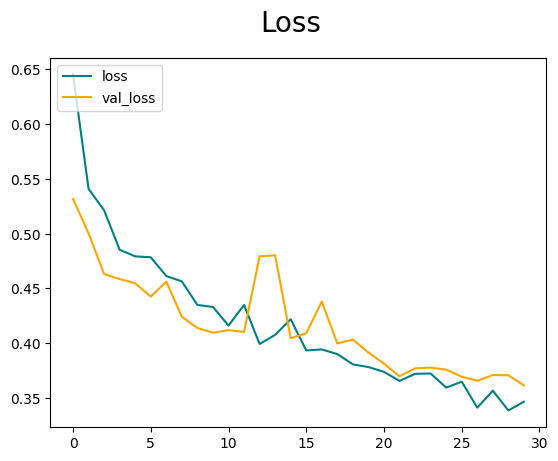

In [65]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

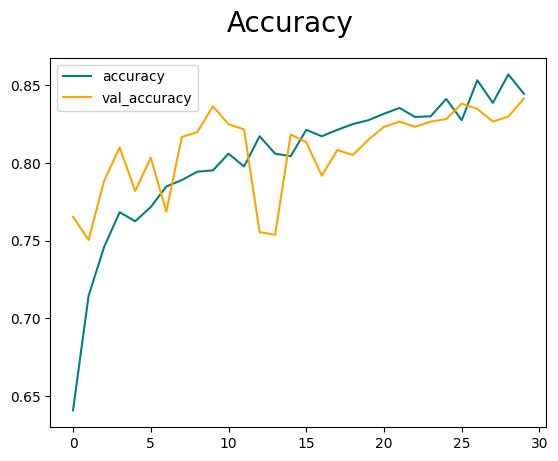

In [66]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 6. Evaluate

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

19/19 [==============================] - 1s 70ms/step - loss: 0.3615 - accuracy: 0.8413
Test accuracy: 0.8413223028182983


#7.saving the model

In [68]:
model.save("happy_sad_mod.keras")

In [69]:
testing_mod = load_model("happy_sad_mod.keras")

###7.1 Saving as pickel

In [70]:
with open('happy_sad_mod.pkl', 'wb') as file:
    pickle.dump(model, file)
    print("model is succesfully saved as ")

model is succesfully saved as 


#8. testing with random picture

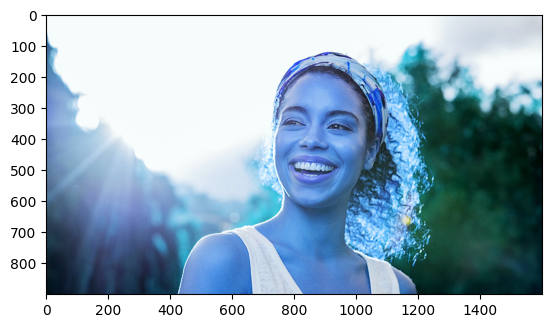

In [71]:
# File path of the image
img_path = '/content/drive/My Drive/happy_sad_mod_c/3h.jpg'

# Read the image using cv2.imread()
img = cv2.imread(img_path)

# Display the image using matplotlib
plt.imshow(img)
plt.show()

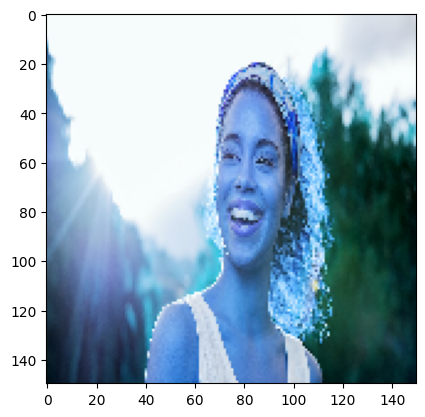

In [72]:
mg_array = np.array(img)

resize = cv2.resize(mg_array, (150, 150))
plt.imshow(resize, cmap='gray')
plt.show()

In [73]:
input_img = np.expand_dims(resize, axis=0)

In [74]:
prediction = testing_mod.predict(input_img)

1/1 [==============================] - 0s 145ms/step


In [75]:
if prediction[0] > 0.5:
    print("The model predicts the image is happy.")
else:
    print("The model predicts the image is sad.")

The model predicts the image is happy.


In [75]:
!git clone <repository_url>